### Housing prices & y transforms

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import scale
from sklearn.metrics import r2_score, explained_variance_score, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.api import OLS

from donatello.components import core, data, transformers, estimator, measure

#### Initial dataset
Housing price data from single family homes in Denver CO

In [2]:
prices = pd.read_csv('../data/single_family_home_values.csv')
prices['last_sale_date'] = pd.to_datetime(prices['last_sale_date'])
display(prices.shape)
prices.head()

(3417, 14)

,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value
0,2495 S Milwaukee St,Denver,CO,80210,Single Family Residence,3885,7500.0,13,4,5.0,2010,350000,2010-06-07,1684147
1,2690 Niagara St,Denver,CO,80207,Single Family Residence,1343,7500.0,6,3,1.0,1948,31500,1978-02-01,343104
2,3425 Grove St,Denver,CO,80211,Single Family Residence,992,6250.0,5,2,2.0,1921,258000,2002-02-19,510436
3,4794 Claude Ct,Denver,CO,80216,Single Family Residence,491,2990.0,3,1,1.0,1891,0,2011-04-27,184105
4,3640 N Gaylord St,Denver,CO,80205,Single Family Residence,1365,4690.0,6,3,1.0,1912,52600,1980-09-01,390055


#### Augementation
With a larger dataet a model could learn to relate the sale date and sale amount, but if we had an existing measure for this it'd be helpful. Fortunately consumer price index is readily available in csvs! If this wasn't a indepedent measure
and we needed to control for leakage we could embed the merging in donatello's ModelDAG (a lightweight execution graph) but since it's not pernicious we can do it up front for simplicity.

In [3]:
cpi = pd.read_csv('../data/denver_cpi.csv')
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
cpi.head()

,DATE,CUUSA433SAH
0,1984-01-01,104.1
1,1985-01-01,106.8
2,1986-01-01,108.2
3,1987-01-01,109.6
4,1988-01-01,110.0


In [4]:
df = pd.merge_asof(prices.sort_values(by='last_sale_date'), cpi, 
                   left_on='last_sale_date', right_on='DATE', direction='nearest')
df.head()

,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value,DATE,CUUSA433SAH
0,3564 Kearney St,Denver,CO,80207,Single Family Residence,1008,6410.0,6,3,1.0,1954,50600,1966-04-14,340952,1984-01-01,104.1
1,1585 S Meade St,Denver,CO,80219,Single Family Residence,947,6010.0,5,3,1.0,1952,21500,1975-02-01,257016,1984-01-01,104.1
2,63 Yates St,Denver,CO,80219,Single Family Residence,803,6250.0,4,2,1.0,1955,25000,1975-03-01,241671,1984-01-01,104.1
3,3020 Newton St,Denver,CO,80211,Single Family Residence,2000,6350.0,9,4,3.0,1909,15000,1975-03-01,762124,1984-01-01,104.1
4,2481 S Holly Pl,Denver,CO,80222,Single Family Residence,2398,13024.0,0,4,3.0,1957,45000,1975-03-01,554375,1984-01-01,104.1


In [5]:
def load_sculpture(df, 
                   model=LinearRegression(), 
                   paramGrid=None,
                   searchKwargs=None):

    """
    Helper to load sculpture
    """
    d = data.Dataset(raw=df, target='estimated_value')
    
    e = estimator.Estimator(model=model, paramGrid=paramGrid, searchKwargs=searchKwargs)
    
    # sklearn metrics
    m = [measure.Metric(metric) for metric in (r2_score, explained_variance_score, median_absolute_error)]
    # donatello custom metric
    m.append(measure.FeatureWeights())
    
    sculpture = core.Sculpture(dataset=d, estimator=e, metrics=m,
                               validation=True, holdout=True)

    return sculpture


In [6]:
df.select_dtypes(pd.np.number).drop('zipcode', axis=1).head()

,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,estimated_value,CUUSA433SAH
0,1008,6410.0,6,3,1.0,1954,50600,340952,104.1
1,947,6010.0,5,3,1.0,1952,21500,257016,104.1
2,803,6250.0,4,2,1.0,1955,25000,241671,104.1
3,2000,6350.0,9,4,3.0,1909,15000,762124,104.1
4,2398,13024.0,0,4,3.0,1957,45000,554375,104.1


In [7]:
df.shape

(3417, 16)

In [8]:
sculpture = load_sculpture(df.select_dtypes(pd.np.number).drop('zipcode', axis=1))

In [9]:
sculpture.fit()

Cross Validation
Holdout


Sculpture_2019_05_30_08_16

In [10]:
from donatello.utils.helpers import view_sk_metric

for name, scores in sculpture.measurements.crossValidation.items():
    if name != 'feature_weights':
        display(view_sk_metric(scores).rename(columns={'score': name}))
    else:
        display(pd.concat([scores.mean.rename(columns={i: '{}_mean'.format(i) for i in scores.mean}), 
                           scores.std.rename(columns={i: '{}_std'.format(i) for i in scores.std})],
                           axis=1).sort_values('coefficients_mean')
               )


,explained_variance_score
mean,0.554218
std,0.110623


,median_absolute_error
mean,100567.159569
std,3823.070881


,r2_score
mean,0.55326
std,0.11104


,coefficients_mean,coefficients_std
names,,
num_bedrooms,-91304.582962,4951.036085
year_built,-361.945991,68.452083
lot_size,-0.794809,0.477008
last_sale_amount,0.036801,0.037641
CUUSA433SAH,30.684390,97.998081
square_footage,343.798942,12.476631
num_rooms,12599.464578,2297.284636
num_baths,30469.476263,10992.537817
intercept_,778380.066873,127041.245944


#### target transforms on an execution graph

Scikit-learn currently doesn't support y transforms or record number modify transform (imblearn does, but places
restrictions on what types of transformers can be embedded in Pipelines)

Donatello has you covered.

The Apply and AccessTransformer allows you to inject a transform function that modifes the design, the target, or both and can be applied only during fit or 

In [11]:
def build_mask(dataset, columns, threshold):
    X = scale(dataset.designData[columns])
    y = dataset.targetData.values
    model = OLS(y, X)
    mask = pd.np.abs((model.fit().outlier_test()[:, 0]) < threshold)
    return mask

def transform(dataset, columns=('square_footage', 'num_bedrooms', 'last_sale_amount'), threshold=2):
    columns = list(columns) if columns else list(dataset.designData)
    mask = build_mask(dataset, columns, threshold)
    X = dataset.designData.loc[mask]
    y = dataset.targetData.loc[mask]
    return X, y

Here we use the fitOnly option to apply this transformation on fitting pipeline but not the scoring pipeline. 

In [12]:
outlier_removal = transformers.Apply(func=transform, fitOnly=True)

In [13]:
d = sculpture.dataset
d_t = outlier_removal.fit_transform(dataset=d)

/Users/markweiss/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


QA dataset sizes for a given response (also note the subet method if you're not familiar with it). The last member demonstrates the already fit transformer not altering the dataset

In [14]:
len(d), len(d.subset('train')), len(d_t), len(d_t.designTrain), len(outlier_removal.transform(dataset=d_t.subset('train')))

Apply_[no_init_time] - fitOnly transformer - passing through


(3417, 2733, 3360, 2688, 2688)

In [15]:
def plot(columns=['square_footage', 'num_bedrooms']):
    mask = build_mask(d.subset('train'), columns, 2)
    
    for column in columns:
        plt.figure(figsize=(18,8))
        plt.xlim(0, d.designTrain[column].quantile(.98) * 1.05) 
        plt.ylim(0, d.targetTrain.max() * 1.01) 
        plt.plot(d.designTrain.loc[mask, column].values, d.targetData.loc[mask].values, 'b.', alpha=.1)
        plt.plot(d.designTrain.loc[~mask, column].values, d.targetTrain.loc[~mask].values, 'r*', alpha=.75)
        plt.legend(['inliers', 'outliers'])
        plt.xlabel(column)
        plt.ylabel('expected price in current USD')
        plt.show()

/Users/markweiss/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


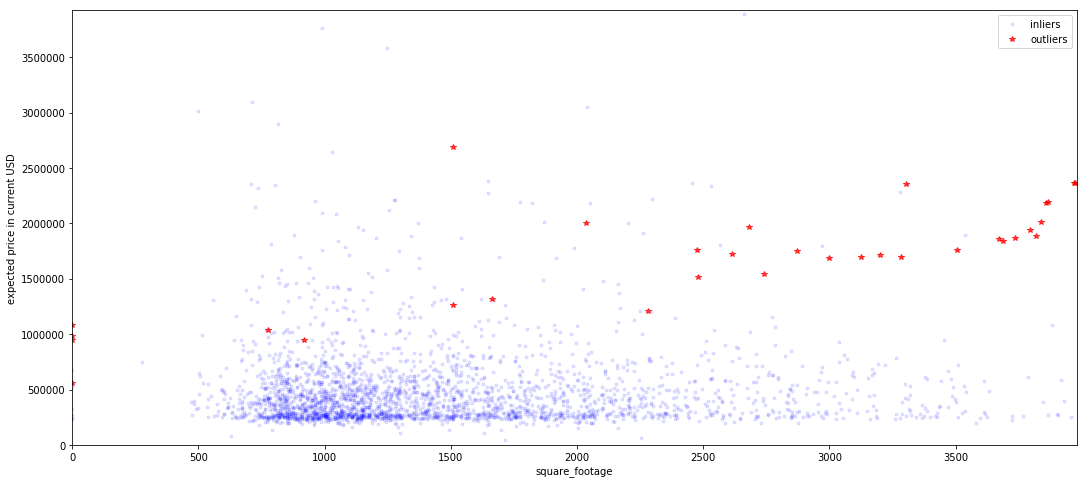

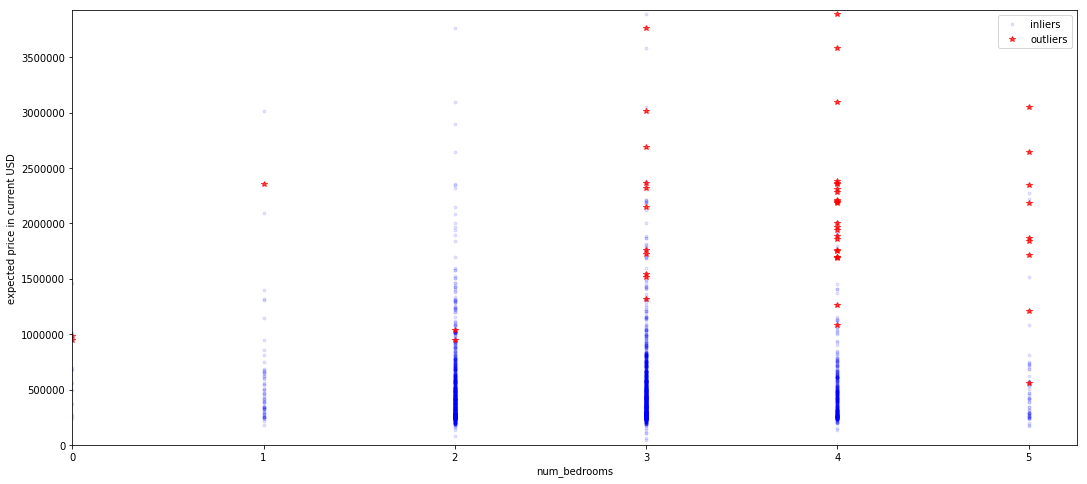

In [16]:
plot()

Donatello's execution graph is built on top of networkx and scikit-learn. To ensure parameters are passed through, and estimator clones are performed properly, the ModelDAG requires a set of nodes and a dict of edges. The graph can be intialized with these but  it's typically easier to use the helper methods to build the graph.

Scikit-learn transformers do not natively enable passing the target through, 

In [17]:
model = transformers.ModelDAG(set([]), {})
n1 = transformers.Node('scale', transformers.StandardScaler(), enforceTarget=True)
n2 = transformers.Node('rm_outliers', transformers.Apply(func=transform, fitOnly=True))
n3 = transformers.Node('ml', LinearRegression())

In [18]:
model.add_edge_flow(n1, n2)
model.add_edge_flow(n2, n3)

In [19]:
sculpture = load_sculpture(df.select_dtypes(pd.np.number).drop('zipcode', axis=1).astype(float), model=model)

In [20]:
sculpture.fit()

Cross Validation
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Holdout
Apply_[no_init_time] - fitOnly transformer - passing through


Sculpture_2019_05_30_08_17

In [21]:
for name, scores in sculpture.measurements.crossValidation.items():
    if name != 'feature_weights':
        display(view_sk_metric(scores).rename(columns={'score': name}))
    else:
        display(pd.concat([scores.mean.rename(columns={i: '{}_mean'.format(i) for i in scores.mean}), 
                           scores.std.rename(columns={i: '{}_std'.format(i) for i in scores.std})],
                           axis=1).sort_values('coefficients_mean')
               )


,explained_variance_score
mean,0.558581
std,0.061935


,median_absolute_error
mean,94755.617899
std,5280.675622


,r2_score
mean,0.556026
std,0.062935


,coefficients_mean,coefficients_std
names,,
num_bedrooms,-64693.487437,2570.268460
year_built,-41758.995713,6855.093092
lot_size,-13700.718409,3702.407919
CUUSA433SAH,5194.435849,2684.496007
last_sale_amount,17017.633934,9878.614885
num_rooms,20235.015009,3802.519509
num_baths,31537.118397,9999.725428
square_footage,220052.808761,6828.259413
intercept_,477679.716399,2645.771120


## Branching
Scikit-learn enables branching feature engineering by nesting FeatureUnions and Pipelines. While servicable, this interface can be hard to manage and makes it more difficult to share transformers and components between problems.

To support this feature, the edges of donatello's ModelDAG are actually transformers themselves with the sole task of passing (conducting) data through them. Conduction transformers follow a pattern. By default all columns/keys found during fitting will be passed along but the ModelDAG's add_edge_conductor method makes it easy to modify these options but selecting or inverting (selecting all but) the columns seen during fit by name, a regex match, or dtype.  

In [22]:
model = transformers.ModelDAG(set([]), {})
# intitate branching by selecting all
n0 = transformers.Node('select', transformers.DatasetFlow(invert=True)) 

# first branch
n11 = transformers.Node('ohe', transformers.OneHotEncoder(dropOne=True))

# second branch
n21 = transformers.Node('scale', transformers.StandardScaler(), enforceTarget=True)
n22 = transformers.Node('rm_outliers', transformers.Apply(func=transform, fitOnly=True))

# terminal node
n3 = transformers.Node('ml', LinearRegression())

In [23]:
# send zipcode data only to OHE and don't pass target through first branch
model.add_edge_flow(n0, n11, passTarget=False, selectValue=['zipcode'], invert=False)
# send output of ohe to Linear Regression 
model.add_edge_flow(n11, n3)

# send all other design data and the target through second branch
model.add_edge_flow(n0, n21, selectValue=['zipcode'], invert=True)
model.add_edge_flow(n21, n22)
model.add_edge_flow(n22, n3)

In [24]:
sculpture = load_sculpture(df.select_dtypes(pd.np.number).astype(float), model=model)

In [25]:
sculpture.fit()

Cross Validation
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Apply_[no_init_time] - fitOnly transformer - passing through
Holdout
Apply_[no_init_time] - fitOnly transformer - passing through


Sculpture_2019_05_30_08_17

In [26]:
print('{} fold validation'.format(sculpture.dataset.fold.folder.get_n_splits()))
for name, scores in sculpture.measurements.crossValidation.items():
    if name != 'feature_weights':
        display(view_sk_metric(scores).rename(columns={'score': name}))
    else:
        display(pd.concat([scores.mean.rename(columns={i: '{}_mean'.format(i) for i in scores.mean}), 
                           scores.std.rename(columns={i: '{}_std'.format(i) for i in scores.std})],
                           axis=1).sort_values('coefficients_mean')
               )


5 fold validation


,explained_variance_score
mean,0.749091
std,0.044543


,median_absolute_error
mean,61437.632107
std,4506.724301


,r2_score
mean,0.747221
std,0.044210


,coefficients_mean,coefficients_std
names,,
zipcode_46926.0,-3.497458e+05,9.342515e+04
zipcode_37134.0,-2.576103e+05,8.583484e+04
zipcode_80249.0,-2.528603e+05,8.174263e+04
zipcode_80219.0,-1.859698e+05,NaN
zipcode_80239.0,-1.427271e+05,8.110450e+04
zipcode_80247.0,-1.334592e+05,8.993306e+04
zipcode_80235.0,-1.210530e+05,8.912922e+04
zipcode_80227.0,-1.198548e+05,8.882648e+04
zipcode_80234.0,-9.058705e+04,9.318180e+04
